In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter,defaultdict
import multiprocessing as mp

PATH="/home/yui/Documents/data/recommender/movieLens20M/rating.csv"
df = pd.read_csv(PATH)
df.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


#### Matrix Fatorization
Imagine there is a optimized ratings for all users $N$ and all items $M$, it is a matrix $\hat{R}$ decomposable into user matrix $W$ and item matrix $U$,
$$\begin{align*}
\hat{R} &= WU^\top \\
[N\times M] &= [N\times k][k\times M]
\end{align*}$$

But it is not worthy to compute all ratings since it could require too much computation, it can be rewritten as element form, 
$$\hat{r}_{ij} = w_i^\top u_j$$
where $w_i$ is the row of user matrix $W$, $u$ is the row of item matrx $U$.

To optimize each rating, we can consider the Mean Squared Error (MSE). 

$$J = \sum_{i,j\in\Omega} (r_{ij}-\hat{r}_{ij})^2=\sum_{i,j\in\Omega}(r_{ij}-w_i^\top u_j)^2$$
where $\Omega$ set of pairs $(i,j)$ where user $i$ rated movie $j$.

We solve both $w_i$ and $u_j$ dependence by setting their gradients to zero to reach the local minima, 
$$\begin{align*}
\frac{\partial J}{\partial w_i} = 0 &\quad \frac{\partial J}{\partial u_j} = 0 \\
w_i=\bigg(\sum_{j\in \Psi_i}u_ju_j^\top\bigg)^{-1}\sum_{j\in\Psi_i}r_{ij}u_j &\quad u_j= \bigg(\sum_{i\in\Omega_j }w_iw_i^\top\bigg)^{-1}\sum_{i\in\Omega_j}r_{ij}w_i \\
\end{align*}$$
where $\Psi_i$ set of movies where users has rated, $\Omega_j$ set of users where movies have been rated.

Though they depend on each other, we can still optimize as alternating least squares.

**Advantages**

1. It is a type of dimensionality reduction. If consider both $N$ and $M$ are around $10^6$, the rating matrix can have $10^{12}$ elements. But if it is decomposed with $k=100$, the number of elements is only $2\times(10^6\times 10^2)\approx 10^8$. It is more space efficient.
2. The dimension of $K$ can be the latent features which have some meanings to the data.

In [2]:
def findNMatches(df,targetUser,leastCommon=25,minMoviesWatched=50,noRef=25):
    tardf = df[df["userId"]==targetUser]
    u2m = defaultdict(dict)
    valCountsUserId = df["userId"].value_counts()

    for j in range(tardf.shape[0]):
        movieId = tardf.iloc[j]["movieId"]
        u2m[targetUser][movieId] = tardf.iloc[j]["rating"]
    avg = np.array(list(u2m[targetUser].values())).mean()
    u2m[targetUser] = (u2m[targetUser],avg)
    tarSet = set(u2m[targetUser][0])
    # print(tarSet)
    prevId,storeSet,storeDict = 0,set(),dict()
    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        userId = row["userId"]
        if valCountsUserId[userId]<minMoviesWatched:
            continue
        if userId==targetUser:
            continue
        if userId!=prevId:
            if len(tarSet&storeSet)>=leastCommon:
                avg = np.array(list(storeDict.values())).mean()
                u2m[prevId]=(storeDict,avg)
            storeSet,storeDict=set(),dict()
        prevId = userId
        storeSet.add(row["movieId"])
        storeDict[row["movieId"]]=row["rating"]
        if len(u2m)>noRef:
            break
    return u2m

In [3]:
u2m = findNMatches(df,1)

  0%|          | 14900/20000263 [00:01<35:24, 9408.79it/s] 


Further extend the model, we introduce user bias $b_i$, movie bias $c_j$ and global mean $\mu$, 

$$\hat{r}_{ij}=w_i^\top u_j + b_i+c_j+\mu$$

So the alternating least squares now become,

$$\begin{align*}
w_i&=\bigg(\sum_{j\in \Psi_i}u_ju_j^\top\bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij}-b_i-c_j-\mu)u_j \\
u_j&= \bigg(\sum_{i\in\Omega_j }w_iw_i^\top\bigg)^{-1}\sum_{i\in\Omega_j}(r_{ij}-b_i-c_j-\mu)w_i \\
b_i &= \frac{1}{|\Psi_i|}\sum_{j\in\Psi_i}(r_{ij}-w_i^\top u_j-c_j-\mu)\\
c_j &= \frac{1}{|\Omega_j|}\sum_{i\in\Omega_j}(r_{ij}-w_i^\top u_j-b_i-\mu)
\end{align*}$$

Adding regularization terms into loss function, 

$$J = \sum_{i,j\in\Omega}(r_{ij}-\hat{r}_{ij})^2+\lambda \bigg(\|W\|^2_F+\|U\|_F^2+\|b\|_2^2+\|c\|_2^2\bigg)$$

Finally,

$$\begin{align*}
w_i&=\bigg(\sum_{j\in \Psi_i}u_ju_j^\top + \lambda I\bigg)^{-1}\sum_{j\in\Psi_i}(r_{ij}-b_i-c_j-\mu)u_j \\
u_j&= \bigg(\sum_{i\in\Omega_j }w_iw_i^\top+ \lambda I\bigg)^{-1}\sum_{i\in\Omega_j}(r_{ij}-b_i-c_j-\mu)w_i \\
b_i &= \frac{1}{|\Psi_i|+\lambda}\sum_{j\in\Psi_i}(r_{ij}-w_i^\top u_j-c_j-\mu)\\
c_j &= \frac{1}{|\Omega_j|+\lambda}\sum_{i\in\Omega_j}(r_{ij}-w_i^\top u_j-b_i-\mu)
\end{align*}$$

In [4]:
class MF:
    def __init__(self,u2m,K=100,penalty=0.1):
        self.u2m = u2m
        self.penalty = penalty
        self.K = K
        self.allmovies = dict()
        self.mean,i=0,0
        for candidate in u2m:
            for movie in u2m[candidate][0]:
                t,c = self.allmovies.get(movie,(0,0))
                c+=1
                t+=u2m[candidate][0][movie]
                self.allmovies[movie]=(t,c)
                i+=1
                self.mean+=u2m[candidate][0][movie]
        self.mean/=i
        for movie in self.allmovies:
            t,c = self.allmovies[movie]
            self.allmovies[movie] = (t/c,c)
        self.m2id = {key:i for i,key in enumerate(self.allmovies)}
        self.id2m = {i:key for i,key in enumerate(self.allmovies)}
        self.u2id = {key:i for i,key in enumerate(u2m)}
        self.id2u = {i:key for i,key in enumerate(u2m)}
        self.N = len(u2m)
        self.M = len(self.allmovies)
        self.W = np.random.randn(self.N,self.K)
        self.U = np.random.randn(self.M,self.K)
        self.B = np.random.randn(self.N)
        self.C = np.random.randn(self.M)
    def alternatingLS(self,epochs=1000):
        Js = [self.loss()]
        for e in tqdm(range(epochs)):
            for candidate in self.u2m:
                self.updateW(candidate)
                self.updateB(candidate)
            for movie in self.allmovies:
                self.updateU(movie)
                self.updateC(movie)
            Js.append(self.loss())
        return Js
    def updateW(self,targetUser):
        up,down = 0,0
        bi = self.B[self.u2id[targetUser]]
        for j in self.u2m[targetUser][0]:
            uj = self.U[self.m2id[j]]
            rij = self.u2m[targetUser][0][j]
            cj = self.C[self.m2id[j]]
            up += (rij-bi-cj-self.mean)*uj
            down += np.outer(uj,uj)
        n=len(down)
        self.W[self.u2id[targetUser]]=\
            np.linalg.inv(down+self.penalty*np.identity(n)).dot(up)
    def updateU(self,targetItem):
        up,down=0,0
        cj = self.C[self.m2id[targetItem]]
        for candidate in self.u2m:
            if targetItem not in self.u2m[candidate][0]:
                continue
            wi = self.W[self.u2id[candidate]]
            rij = self.u2m[candidate][0][targetItem]
            bi = self.B[self.u2id[candidate]]
            up += (rij-bi-cj-self.mean)*wi
            down += np.outer(wi,wi)
        n=len(down)
        self.U[self.m2id[targetItem]]=\
            np.linalg.inv(down+self.penalty*np.identity(n)).dot(up)
    def updateB(self,targetUser):
        s=0
        wi = self.W[self.u2id[targetUser]]
        c = len(self.u2m[targetUser][0])
        for j in self.u2m[targetUser][0]:
            rij = self.u2m[targetUser][0][j]
            cj = self.C[self.m2id[j]]
            uj = self.U[self.m2id[j]]
            s+=(rij-wi.T.dot(uj)-cj-self.mean)
        self.B[self.u2id[targetUser]]=s/(c+self.penalty)
    def updateC(self,targetItem):
        s=0
        uj = self.U[self.m2id[targetItem]]
        c = self.allmovies[targetItem][1]
        for candidate in self.u2m:
            if targetItem not in self.u2m[candidate][0]:
                continue
            wi = self.W[self.u2id[candidate]]
            bi = self.B[self.u2id[candidate]]
            rij = self.u2m[candidate][0][targetItem]
            s+=(rij-wi.T.dot(uj)-bi-self.mean)
        self.C[self.m2id[targetItem]]=s/(c+self.penalty)
    def loss(self):
        J = 0
        for candidate in self.u2m:
            for movie in self.u2m[candidate][0]:
                rij = self.u2m[candidate][0][movie]
                wi = self.W[self.u2id[candidate]]
                uj = self.U[self.m2id[movie]]
                bi = self.B[self.u2id[candidate]]
                cj = self.C[self.m2id[movie]]
                J+=(rij-wi.T.dot(uj)-bi-cj-self.mean)**2
        return J

In [5]:
mf = MF(u2m)

In [6]:
epochs = 100
Js = mf.alternatingLS(epochs=epochs)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


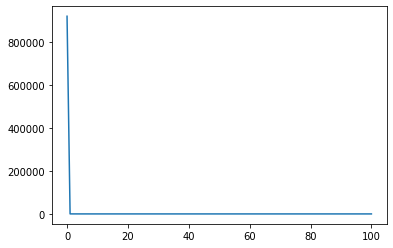

In [7]:
plt.plot(range(epochs+1),Js)

#### Compare Ground Truth

In [8]:
targetUser,limit = 1,10
for i,movie in enumerate(mf.u2m[targetUser][0]):
    pred = mf.W[mf.u2id[targetUser]].T.dot(mf.U[mf.m2id[movie]])
    pred += mf.mean
    pred += mf.B[targetUser]
    pred += mf.C[mf.m2id[movie]]
    print("Movie {}: {} (truth) {} (predict)".format(\
        movie,mf.u2m[1][0][movie],pred))
    if i==10:
        break

Movie 2: 3.5 (truth) 3.8641300336631623 (predict)
Movie 29: 3.5 (truth) 3.8648064809412044 (predict)
Movie 32: 3.5 (truth) 3.8717774364095674 (predict)
Movie 47: 3.5 (truth) 3.8767950477986477 (predict)
Movie 50: 3.5 (truth) 3.872220679830462 (predict)
Movie 112: 3.5 (truth) 3.865349967672109 (predict)
Movie 151: 4.0 (truth) 4.3583792140853275 (predict)
Movie 223: 4.0 (truth) 4.357461098814121 (predict)
Movie 253: 4.0 (truth) 4.362300383977879 (predict)
Movie 260: 4.0 (truth) 4.361746296378296 (predict)
Movie 293: 4.0 (truth) 4.3604240749456125 (predict)


#### New suggestions

In [9]:
res = []
for i,movie in enumerate(mf.allmovies):
    if movie in mf.u2m[targetUser][0]:
        continue
    pred = mf.W[mf.u2id[targetUser]].T.dot(mf.U[mf.m2id[movie]])
    pred += mf.mean
    pred += mf.B[targetUser]
    pred += mf.C[mf.m2id[movie]]
    heappush(res,(-pred,movie))


In [10]:
res[:10]

[(-4.625469862065435, 1210),
 (-4.613845294378064, 356),
 (-4.572742889837487, 2858),
 (-4.404287744570658, 457),
 (-4.487730889703764, 7361),
 (-4.2959470221008305, 33794),
 (-4.404815374578511, 1356),
 (-4.328141147572148, 475),
 (-4.339826666156794, 1206),
 (-4.389067685816456, 904)]